In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [5]:
import time, sys

# utility function fr progress bar 
# see https://stackoverflow.com/questions/3160699/python-progress-bar for more details
def update_progress(progress):
    barLength = 10 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1:.2f}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [6]:
def log_pi(X, B):
    n = len(X)
    grad = np.array([-X[i] for i in range(n)])
    grad[0] = -2/100*X[0] - 2*X[0]*(X[1] + B*X[0]**2-100*B)
    grad[1] = -(X[1] + B*X[1]**2 - 100*B)
    return grad

In [7]:
def generate_drift(X, grad_log_pi, B, delta, sigma, gamma):
    grad = grad_log_pi(X,B)
    D_mala = delta/(max(delta, np.abs(grad)))*grad
    

In [70]:
class adaptative_MALA:
    
    def __init__(self, X, delta, B, mu_0, sigma_0, Gamma_0, tau, c_0, epsilon_1, epsilon_2, A_1, drift=True, adaptative=True):
        self.X = X
        self.delta = delta
        self.B = B
        self.mu = mu_0
        self.sigma = sigma_0
        self.Gamma = Gamma_0
        self.Lambda = Gamma_0 + epsilon_2*np.eye(len(Gamma_0))
        self.n = len(X)
        self.tau = tau
        self.c_0 = c_0
        self.gamma = c_0
        self.epsilon_1 = epsilon_1
        self.epsilon_2 = epsilon_2
        self.A_1 = A_1
        self.D_mala = None
        self.alpha = None
        self.drift = drift
        self.adaptative = adaptative
        self.Alpha = []
        self.mean_Alpha = []
    
    def grad_log_pi(self):
        grad = np.array([-self.X[i] for i in range(self.n)])
        grad[0] = -1/100*self.X[0] - 2*self.B*self.X[0]*(X[1] + self.B*self.X[0]**2-100*self.B)
        grad[1] = -(self.X[1] + self.B*self.X[0]**2 - 100*self.B)
        return grad
    
    def generate_drift(self):
        if self.drift:
            grad = self.grad_log_pi()
            self.D_mala = self.delta/(max(self.delta, np.linalg.norm(grad)))*grad
            return np.random.multivariate_normal(self.X + self.sigma**2/2*self.Lambda@self.D_mala, self.sigma**2*self.Lambda)
        else:
            return np.random.multivariate_normal(self.X, self.sigma**2*self.Lambda)
    
    def log_gaussienne(self, X, Y):
        if self.drift:
            mu = X + self.sigma**2/2*self.Lambda@self.D_mala
        else:
            mu = X
        return -1/2*(Y - mu).T@np.linalg.inv(self.sigma**2*self.Lambda)@(Y - mu)
    
    def log_loi(self, X):
        res = -(X[0]**2)/200 - 1/2*(X[1] + self.B*X[0]**2 - 100*self.B)**2
        return res - 1/2*np.sum(np.square(X[2:]))
    
    def MH_step(self):
        Y = self.generate_drift()
        log_alpha = min(0, self.log_gaussienne(Y,X)*self.log_loi(Y) - self.log_gaussienne(X,Y)*self.log_loi(X))
        u = np.random.random()
        if np.log(u) < log_alpha:
            self.X = Y
        self.alpha = np.exp(log_alpha)
        self.Alpha.append(self.alpha)
        self.mean_Alpha.append(np.mean(np.array(self.Alpha)))
    
    def p_1(self, sigma):
        if sigma < self.epsilon_1:
            return self.epsilon_1
        elif sigma > self.A_1:
            return A_1
        else:
            return sigma
    
    def p_2(self, sigma):
        norme_sigma = np.sqrt(np.trace(sigma@sigma))
        if norme_sigma < self.A_1:
            return sigma
        else:
            return self.A_1/norme_sigma*sigma
    
    def p_3(self, x):
        norme_x = np.linalg.norm(x)
        if norme_x < self.A_1:
            return x
        else:
            return A_1/norme_x*x

    def update(self):
        
        self.mu = self.p_3(self.mu + self.gamma*(self.X-self.mu))
        self.Gamma = self.p_2(self.Gamma + self.gamma*(np.outer((self.X-self.mu), (self.X-self.mu)) - self.Gamma))
        self.Lambda = self.Gamma + self.epsilon_2*np.eye(len(self.Gamma))
        self.sigma = self.p_1(self.sigma + self.gamma*(np.exp(self.alpha) - self.tau))
    
    def run(self, maxIter=50000, sample=3000, batch = 5000):
        RES = []
        for i in range(maxIter):
            update_progress(i/maxIter)
            self.MH_step()
            if i != 0:
                self.gamma = self.c_0/i
            if self.adaptative and i%batch == 0 and i != 0:
                self.update()
            RES.append(self.X)
        return RES[sample:]
        
        

In [71]:
delta = 1000
tau = 0.5
epsilon_1 = pow(10, -7)
epsilon_2 = pow(10, -6)
A_1 = np.power(10, 7)
c_0 = 10
B = .1
mu_0 = np.array([0 for i in range(2)])
sigma_0 = 0.49
Gamma_0 = np.array([[1,0], [0,1]])# np.loadtxt("tmalaexcov.txt", dtype=float)
X = np.array([0 for i in range(2)])

In [72]:
test = adaptative_MALA(X, delta, B, mu_0, sigma_0, Gamma_0, tau, c_0, epsilon_1, epsilon_2, A_1, drift=True, adaptative=False)

In [73]:
RES = test.run()

Percent: [##########] 100.00% 

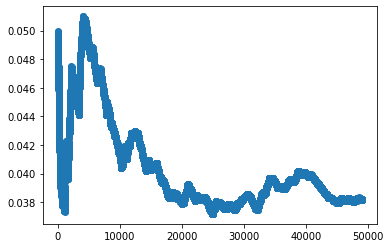

In [74]:
Alpha = test.mean_Alpha[1000:]
alpha_x = np.array([alpha for alpha in Alpha])
t = [i for i in range(len(Alpha))]
plt.plot(t, alpha_x, "o")
plt.show()

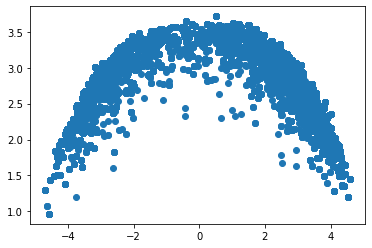

In [75]:
x = np.array([res[0] for res in RES])
y = np.array([res[1] for res in RES])
#sns.kdeplot(x=x, y=y, cmap="Reds", shade=True, bw_adjust=.5)
#plt.show()
plt.plot(x,y, "o")
plt.show()

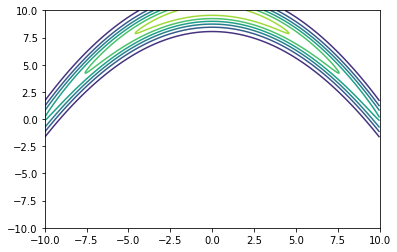

In [238]:
B=0.1
side = np.linspace(-10,10,1000)
X, Y = np.meshgrid(side,side)
# facteur de normalisation pret
Z = np.exp(-(X**2)/200 - 1/2*(Y + B*X**2 - 100*B)**2)

# Plot the density map using nearest-neighbor interpolation
#plt.xlim(-10, 10)
#plt.ylim(-15, 15)
plt.contour(X,Y,Z)
plt.show()

In [76]:
test = np.array([1,2,3,4,5])
np.square(test)

array([ 1,  4,  9, 16, 25])

In [77]:
def crosscorrel(x, y, max_lag=None):
    if max_lag is None:
        max_lag =  len(x)
    sx = pd.Series(x)
    sy = pd.Series(y)
    res = np.zeros(max_lag)
    for lag in range(1, max_lag):
        res[lag] = sx.corr(sy.shift(lag))
    res[0] = 1
    return res

In [78]:
x = np.array([res[0] for res in RES[140:]])
y = np.array([res[1] for res in RES[140:]])
#print(x)

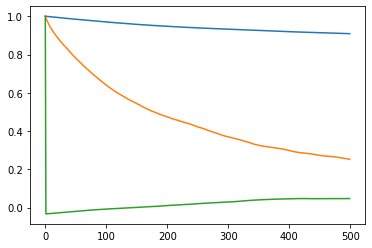

In [79]:
plt.plot(crosscorrel(x, x, max_lag=500), label="x,x")
plt.plot(crosscorrel(y, y, max_lag=500), label="y,y")
plt.plot(crosscorrel(x, y, max_lag=500), label="x,y")
plt.show()

Adaptative 

In [80]:
delta = 1000
tau = 0.5
epsilon_1 = pow(10, -7)
epsilon_2 = pow(10, -6)
A_1 = np.power(10, 7)
c_0 = 10
B = .1
mu_0 = np.array([0 for i in range(2)])
sigma_0 = 0.4
Gamma_0 = np.array([[1,0], [0,1]])# np.loadtxt("tmalaexcov.txt", dtype=float)
X = np.array([0 for i in range(2)])

In [81]:
test = adaptative_MALA(X, delta, B, mu_0, sigma_0, Gamma_0, tau, c_0, epsilon_1, epsilon_2, A_1, drift=True, adaptative=True)

In [82]:
RES = test.run()

Percent: [##########] 100.00% 

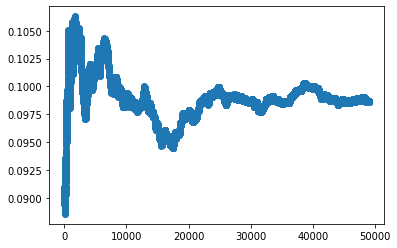

In [83]:
Alpha = test.mean_Alpha[1000:]
alpha_x = np.array([alpha for alpha in Alpha])
t = [i for i in range(len(Alpha))]
plt.plot(t, alpha_x, "o")
plt.show()

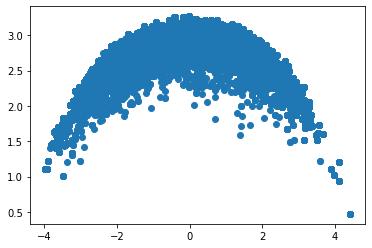

In [84]:
x = np.array([res[0] for res in RES])
y = np.array([res[1] for res in RES])
#sns.kdeplot(x=x, y=y, cmap="Reds", shade=True, bw_adjust=.5)
#plt.show()
plt.plot(x,y, "o")
plt.show()

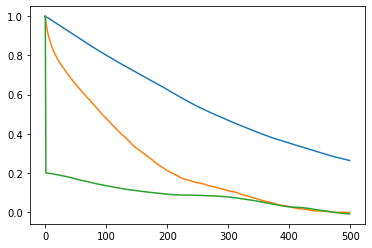

In [85]:
plt.plot(crosscorrel(x, x, max_lag=500), label="x,x")
plt.plot(crosscorrel(y, y, max_lag=500), label="y,y")
plt.plot(crosscorrel(x, y, max_lag=500), label="x,y")
plt.show()